In [1]:
import pandas as pd
import collections
import numpy as np

In [2]:
data = pd.read_csv("rt_reviews.csv", encoding='ISO-8859-1')

In [3]:
data.head()

,Freshness,Review
0,fresh,"Manakamana doesn't answer any questions, yet ..."
1,fresh,Wilfully offensive and powered by a chest-thu...
2,rotten,It would be difficult to imagine material mor...
3,rotten,Despite the gusto its star brings to the role...
4,rotten,If there was a good idea at the core of this ...


In [4]:
len(data)

480000

In [6]:
# Using 50% data for training 
# Using 30% data for development dataset 
# Using 20% data for testing

train_ratio = 0.5
dev_ratio = 0.3
test_ratio = 0.2

total_rows = len(data)
train_idx = int(train_ratio * total_rows)
dev_idx = int((train_ratio + dev_ratio) * total_rows)

shuffled_data = data.sample(frac=1, random_state=42)

train_data = shuffled_data.iloc[:train_idx, :]
dev_data = shuffled_data.iloc[train_idx:dev_idx, :]
test_data = shuffled_data.iloc[dev_idx:, :]


In [7]:
# Combining all the reviews to create the inverted indices
# we are ignoring the class to which the review belongs to
# this is becasue class is not relavent
all_reviews = ' '.join(data['Review'].tolist())
# getting the tokens
tokens = all_reviews.split()

# getting word count, we use collections library to count the words frequency
word_counts = collections.Counter(tokens)

# filtering the rare words, only keeping the words that have frequency bigger than 5
filtered_words = [word for word, count in word_counts.items() if count >= 5]
# making the vocabulary 
vocabulary = sorted(set(filtered_words))
# generating reverse indices
reverse_index = {word: idx for idx, word in enumerate(vocabulary)}

print("Vocabulary:")
print(vocabulary[:10])  
print("\nReverse Index:")
print(dict(list(reverse_index.items())[:10]))

Vocabulary:
['"A', '"Alien"', '"All', '"American', '"Black', '"Dark', '"Don\'t', '"Fantastic', '"Fifty', '"First']

Reverse Index:
{'"A': 0, '"Alien"': 1, '"All': 2, '"American': 3, '"Black': 4, '"Dark': 5, '"Don\'t': 6, '"Fantastic': 7, '"Fifty': 8, '"First': 9}


In [8]:
word = "the"
sentiment = "fresh"
# finding the documents that contain this word
num_docs_with_word = data['Review'].apply(lambda x: word in x).sum()

# Probability that a document will contain the word the
p_word = num_docs_with_word / len(data)

# extracting all reviews that say fresh
fresh_reviews = data[data['Freshness'] == sentiment]

# number of documents that contain the word in fresh class
num_pos_docs_with_word = fresh_reviews['Review'].apply(lambda x: word in x).sum()

# probability that the word is present given the review is fresh
p_word_given_fresh = num_pos_docs_with_word / len(fresh_reviews)

print(f'P("{word}") = {p_word}')
print(f'P("{word}" | {sentiment}) = {p_word_given_fresh}')


P("the") = 0.6495
P("the" | fresh) = 0.6494352952883228


In [9]:

# This will be used to extract binary features
def extract_features(review, vocabulary):
    features = np.zeros(len(vocabulary), dtype=int)
    words = review.split()
    for word in words:
        if word in vocabulary:
            index = reverse_index[word]
            features[index] = 1
    return features

num_classes = 2  #we have two classes fresh and rotten


In [10]:
# Extracting features
train_features = np.array([extract_features(review, vocabulary) for review in train_data['Review']])
train_labels = (train_data['Freshness'] == 'fresh').astype(int)
test_features = np.array([extract_features(review, vocabulary) for review in test_data['Review']])
test_labels = (test_data['Freshness'] == 'fresh').astype(int)
dev_features = np.array([extract_features(review, vocabulary) for review in dev_data['Review']])
dev_labels = (dev_data['Freshness'] == 'fresh').astype(int)

In [11]:
alpha = 1  # using alpha = 1 for smoothing

# Calculating prior class probabilities
class_priors = np.zeros(num_classes)
for c in range(num_classes):
    class_priors[c] = (train_labels == c).sum() / len(train_labels)

# Calculating class-conditional probabilities
class_conditional_probs = np.zeros((num_classes, len(vocabulary)))
for c in range(num_classes):
    class_docs = train_features[train_labels == c]
    class_word_counts = class_docs.sum(axis=0)
    class_total_words = class_docs.sum()
    class_conditional_probs[c] = (class_word_counts + alpha) / (class_total_words + alpha * len(vocabulary))

In [12]:
# Predicting freshness for dev data using Naive Bayes classifier
predictions = np.zeros(dev_features.shape[0], dtype=int)
for i, review_features in enumerate(dev_features):
    # Calculating the log probabilities
    log_probs = np.log(class_priors) + np.dot(review_features, np.log(class_conditional_probs).T)
    predictions[i] = np.argmax(log_probs)
accuracy = (predictions == dev_labels).sum() / len(dev_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 73.97%


In [13]:
# Testing our code with different smoothing values
alphas = [0, 0.1, 0.5, 1, 2, 5, 10] 
# To store the best value of alpha, initializing to -1 and setting accuracy to 0
optimal_alpha = {"alpha": -1, "accuracy":0}
for alpha in alphas:
    # Calculating class-conditional probabilities using different alpha values
    class_conditional_probs = np.zeros((num_classes, len(vocabulary)))
    for c in range(num_classes):
        class_docs = train_features[train_labels == c]
        class_word_counts = class_docs.sum(axis=0)
        class_total_words = class_docs.sum()
        class_conditional_probs[c] = (class_word_counts + alpha) / (class_total_words + alpha * len(vocabulary))

    # Predicting the freshness
    predictions = np.zeros(test_features.shape[0], dtype=int)

    for i, review_features in enumerate(test_features):
        log_probs = np.log(class_priors) + np.dot(review_features, np.log(class_conditional_probs).T)
        predictions[i] = np.argmax(log_probs)

    # Calculating the frequency
    accuracy = (predictions == test_labels).sum() / len(test_labels)
    # If current alpha gives the optimal accuracy, updating optimal alpha
    if accuracy > optimal_alpha["accuracy"]:
        optimal_alpha = {"alpha": alpha, "accuracy":accuracy}
    
    print(f"Alpha: {alpha}, Accuracy: {accuracy * 100:.2f}%")
    


<ipython-input-13-04cdf90c4de6>:18: RuntimeWarning: divide by zero encountered in log
  log_probs = np.log(class_priors) + np.dot(review_features, np.log(class_conditional_probs).T)


Alpha: 0, Accuracy: 49.16%
Alpha: 0.1, Accuracy: 72.75%
Alpha: 0.5, Accuracy: 73.83%
Alpha: 1, Accuracy: 73.90%
Alpha: 2, Accuracy: 74.22%
Alpha: 5, Accuracy: 74.01%
Alpha: 10, Accuracy: 73.20%


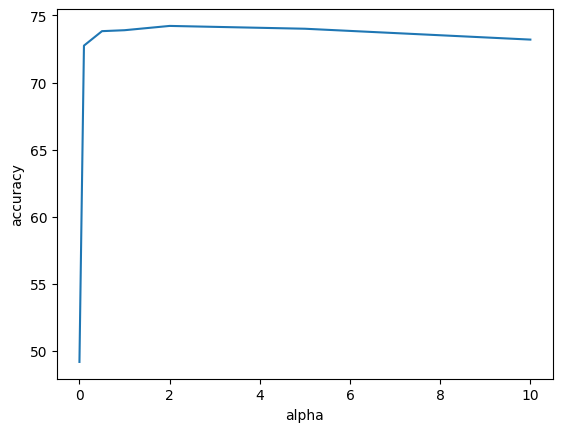

In [14]:

import matplotlib.pyplot as plt
ypoints = np.array([49.16,72.75,73.83,73.90,74.22,74.01,73.20])
xpoints = np.array([0, 0.1, 0.5, 1, 2, 5, 10] )

plt.ylabel('accuracy')
plt.xlabel('alpha')
plt.plot(xpoints, ypoints)
plt.show()

In [18]:
# Calculating P(word|class)*P(class) for each class and word
p_word_class = (class_conditional_probs.T * class_priors).T

# Calculating P(word) for each word
p_word = np.sum(p_word_class, axis=0)

# Calculate P(class|word) for each class and word
p_class_given_word = p_word_class / p_word

# Finding the top 10 words
num_top_words = 10
top_words_indices =np.argpartition(p_class_given_word, -num_top_words, axis=1)[:,-num_top_words:]

# Map the topwords indices to words
top_words= {}
for c in range(num_classes):
    top_words[c] = [vocabulary[i] for i in top_words_indices[c]]

# Display the top 10 words for each class
for c, words in top_words.items():
    class_name = "fresh" if c != 0 else "rotten"
    print(f"Top 10 words in {class_name}:")
    print(", ".join(words))



Top 10 words in rotten:
boring,, Feels, fails, waste, dull,, forgettable., mess., lame, Sadly,, Unfortunately,
Top 10 words in fresh:
intimate, finest, moving,, outstanding, bittersweet, exquisite, refreshingly, dazzling, quietly, delicate


In [16]:
alpha = optimal_alpha["alpha"]  # using optimal alpha

# Calculating prior class probabilities
class_priors = np.zeros(num_classes)
for c in range(num_classes):
    class_priors[c] = (train_labels == c).sum() / len(train_labels)

# Calculating class-conditional probabilities
class_conditional_probs = np.zeros((num_classes, len(vocabulary)))
for c in range(num_classes):
    class_docs = train_features[train_labels == c]
    class_word_counts = class_docs.sum(axis=0)
    class_total_words = class_docs.sum()
    class_conditional_probs[c] = (class_word_counts + alpha) / (class_total_words + alpha * len(vocabulary))

# Predicting freshness for test data using Naive Bayes classifier
predictions = np.zeros(test_features.shape[0], dtype=int)
for i, review_features in enumerate(test_features):
    # Calculating the log probabilities
    log_probs = np.log(class_priors) + np.dot(review_features, np.log(class_conditional_probs).T)
    predictions[i] = np.argmax(log_probs)
accuracy = (predictions == test_labels).sum() / len(test_labels)
print(f"Final Accuracy: {accuracy * 100:.2f}%")


Final Accuracy: 74.22%
